# Declustering

Jalankan file ini di Openquake yang sudah diinstal di komputer masing-masing.

atau:

Jalankan file ini di jupyter dengan cara mengubah kernel ke `openquake`. Jika kernel `openquake` belum ada, lakukan langkah-langkah berikut ini:

Openquake dapat diunduh di sini:
https://downloads.openquake.org/pkgs/windows/oq-engine/OpenQuake_Engine_3.11.5-1.exe

Install beberapa tambahan packages di openquake:

(Asumsi lokasi instalasi openquake di sini: `C:\Program Files\Openquake Engine\python3.6\`, 
jika tidak maka ubah lokasi tersebut sesuai dengan komputer masing-masing)

1. Buka Command Prompt
2. Install `utm`: `"C:\Program Files\Openquake Engine\python3.6\python.exe" -m pip install utm`
3. Install `jupyter`: `"C:\Program Files\Openquake Engine\python3.6\python.exe" -m pip install jupyter`
4. Daftarkan ke dalam kernel (opsional): `python -m ipykernel install --name "openquake" --display-name "openquake"`


Untuk uji coba, jalankan salah satu baris di bawah ini:

`"C:\Program Files\Openquake Engine\python3.6\Scripts\jupyter.exe" notebook`

atau

`"C:\Program Files\Openquake Engine\python3.6\Scripts\jupyter-notebook.exe"`

## 1. Download data katalog

Download data katalog di sini:

http://isc.ac.uk/iscbulletin/search/catalogue/

lalu susun data katalog tersebut ke dalam format csv berikut ini:
```
eventID,year,month,day,hour,minute,second,longitude,latitude,depth,magnitude,sigmaMagnitude
1451994,1999,02,13,21,46,28.70,102.8258,-4.9794,700,2.1015,0
17198558,2011,03,25,21,44,18.21,109.5132,-5.1621,700,3.71862,0
300154,1992,03,17,19,02,13   ,109.5,-6.5,662,3.3,0
612165570,2018,06,22,20,57,43.65,108.3305,-5.0316,656.4,5.43681,0
484365,1986,10,18,22,09,33.39,109.9477,-5.5495,652.3,5.94216,0
15634840,2010,05,31,15,45,12.82,108.1441,-5.0687,652.1,4.02183,0
...
```

dengan magnitudo dikonversi semua ke dalam Mw (momen magnitudo) berdasarkan konversi PuSGEN 2017:
https://sianipar17.files.wordpress.com/2018/12/nsha_2017.pdf

## 2. Import packages

Hal ini memastikan apakah python yang digunakan sudah menyediakan packages yang dibutuhkan.

In [1]:
from openquake.hmtk.parsers.catalogue import *
from openquake.hmtk.plotting.seismicity.catalogue_plots import *
from openquake.hmtk.seismicity.declusterer.dec_gardner_knopoff import *
from openquake.hmtk.seismicity.declusterer.distance_time_windows import *
from openquake.hmtk.seismicity.selector import *
from openquake.hazardlib.geo.polygon import Polygon as PolyOQ
from openquake.hazardlib.geo.point import Point as PointOQ
from openquake.hazardlib.geo.line import Line as LineOQ
from openquake.hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971
from openquake.hmtk.seismicity.occurrence.b_maximum_likelihood import BMaxLikelihood
from openquake.hmtk.plotting.seismicity.completeness.plot_stepp_1972 import create_stepp_plot
from openquake.hmtk.seismicity.smoothing.smoothed_seismicity import SmoothedSeismicity
from openquake.hmtk.seismicity.smoothing.kernels.isotropic_gaussian import IsotropicGaussian
from openquake.hazardlib.geo.surface.complex_fault import ComplexFaultSurface
from shapely.geometry import *
from shapely.ops import *
import utm
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle

## 3. Tambahan

### 3.1 Fungsi

In [11]:
# membuat colormap diskrit
def get_cmap(n, name='jet'):
    return plt.cm.get_cmap(name, n)

### 3.2 Variabel

In [44]:
# folder penyimpanan
dir_figs = os.path.join(os.getcwd(), 'figs')
os.makedirs(dir_figs, exist_ok=True)

## 4. Katalog gempa

### 4.1 Membaca data katalog dalam format csv

In [2]:
# baca data katalog yang berada di harddisk
catalogue_filename = "katalog-ISC-1964-2021.csv"
parser = CsvCatalogueParser(catalogue_filename)
catalogue = parser.read_file()

### 4.2 Melihat sebaran data berdasarkan waktu kejadian dan magnitudo

<Figure size 640x480 with 0 Axes>

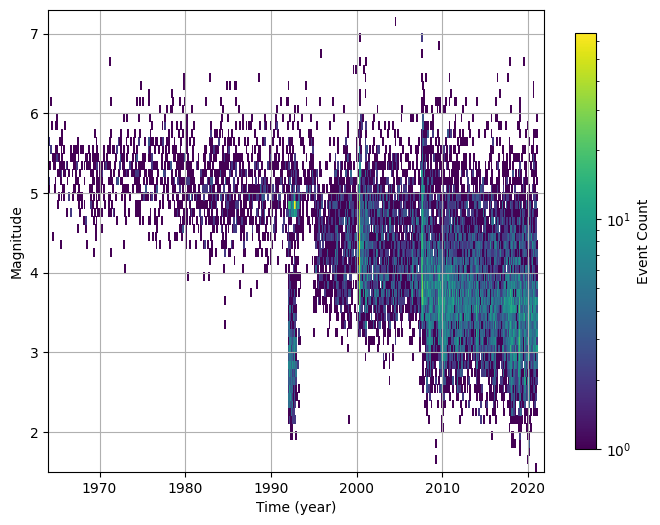

In [48]:
magnitude_bin_width = 0.1
time_bin_width = 0.1

plt.set_cmap('viridis')
plot_magnitude_time_density (catalogue, magnitude_bin_width, time_bin_width)
plt.savefig(os.path.join(dir_figs, 'plot_magnitude_time_density-catalogue.png'), dpi=300)

### 4.3 Simpan data katalog ke format pkl

In [4]:
idcs = ['eventID','year','month','day','hour',
       'minute','second','longitude','latitude',
       'depth','magnitude','sigmaMagnitude']

dict_catalogue = dict()
for idx in idcs:
    if isinstance(catalogue[idx], list): 
        dict_catalogue[idx] = catalogue[idx]
    else:
        dict_catalogue[idx] = catalogue[idx].tolist()

with open('dict_catalogue.pkl', 'wb') as file:
    pickle.dump(dict_catalogue, file)

## 5. Declustering

### 5.1 Proses utama

In [5]:
declust_config = {'time_distance_window': UhrhammerWindow() ,
                  'fs_time_prop': 1.0}

declustering = GardnerKnopoffType1()
cluster_index, cluster_flag = declustering.decluster(catalogue, declust_config)

selectorCatalogue = CatalogueSelector(catalogue, create_copy = True)
catalogue_declustered = selectorCatalogue.select_catalogue(cluster_flag == 0)

print("sebelum didekluster: ", len(catalogue['eventID']), " events")
print("setelah didekluster: ", len(catalogue_declustered['eventID']), " events")

sebelum didekluster:  18032  events
setelah didekluster:  12598  events


### 5.2 Simpan data katalog ke format pkl

In [6]:
idcs = ['eventID','year','month','day','hour',
       'minute','second','longitude','latitude',
       'depth','magnitude','sigmaMagnitude']

dict_catalogue = dict()
for idx in idcs:
    if isinstance(catalogue[idx], list): 
        dict_catalogue[idx] = catalogue_declustered[idx]
    else:
        dict_catalogue[idx] = catalogue_declustered[idx].tolist()

with open('dict_catalogue_declustered.pkl', 'wb') as file:
    pickle.dump(dict_catalogue, file)

### 5.3 Melihat sebaran data berdasarkan waktu kejadian dan magnitudo

<Figure size 640x480 with 0 Axes>

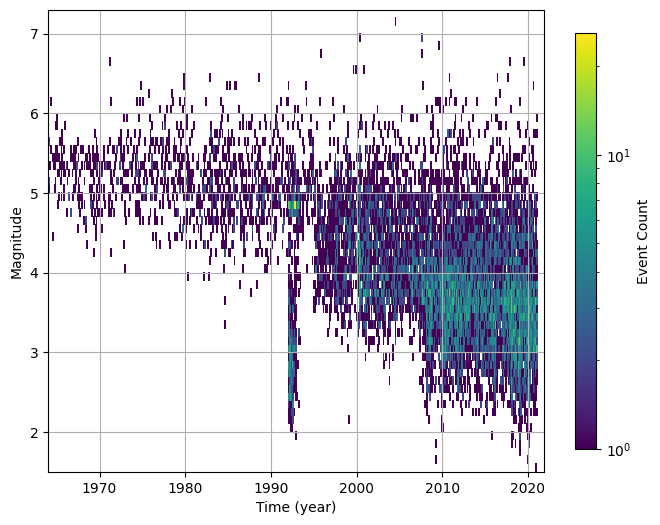

In [49]:
magnitude_bin_width = 0.1
time_bin_width = 0.1

plt.set_cmap('viridis')
plot_magnitude_time_density (catalogue_declustered, magnitude_bin_width, time_bin_width)
plt.savefig(os.path.join(dir_figs, 'plot_magnitude_time_density-catalogue_declustered.png'), dpi=300)

### 5.4 Magnitude of Completeness (Mc)

In [8]:
completeness_algorithm = Stepp1971()

comp_config = {'magnitude_bin': 0.1,
                'time_bin': 5. ,
                'increment_lock': True }

completeness_table_old = completeness_algorithm.completeness(catalogue_declustered, comp_config)
completeness_algorithm.simplify(mag_range=[3., 5.])
completeness_table = completeness_algorithm.completeness_table
Mc_declustered = completeness_table

print("== Keseluruhan Mc ==")
print(completeness_table_old)
print("\n== selected Mc ==")
print(completeness_table)


== Keseluruhan Mc ==
[[2.016e+03 1.400e+00]
 [2.006e+03 1.500e+00]
 [2.006e+03 1.600e+00]
 [2.006e+03 1.700e+00]
 [2.006e+03 1.800e+00]
 [2.006e+03 1.900e+00]
 [2.006e+03 2.000e+00]
 [2.006e+03 2.100e+00]
 [2.006e+03 2.200e+00]
 [2.006e+03 2.300e+00]
 [2.006e+03 2.400e+00]
 [2.006e+03 2.500e+00]
 [2.006e+03 2.600e+00]
 [2.006e+03 2.700e+00]
 [2.006e+03 2.800e+00]
 [2.006e+03 2.900e+00]
 [2.006e+03 3.000e+00]
 [2.006e+03 3.100e+00]
 [2.006e+03 3.200e+00]
 [2.006e+03 3.300e+00]
 [2.006e+03 3.400e+00]
 [2.005e+03 3.500e+00]
 [2.004e+03 3.600e+00]
 [2.002e+03 3.700e+00]
 [1.999e+03 3.800e+00]
 [1.996e+03 3.900e+00]
 [1.996e+03 4.000e+00]
 [1.996e+03 4.100e+00]
 [1.996e+03 4.200e+00]
 [1.996e+03 4.300e+00]
 [1.996e+03 4.400e+00]
 [1.996e+03 4.500e+00]
 [1.990e+03 4.600e+00]
 [1.979e+03 4.700e+00]
 [1.979e+03 4.800e+00]
 [1.979e+03 4.900e+00]
 [1.968e+03 5.000e+00]
 [1.968e+03 5.100e+00]
 [1.968e+03 5.200e+00]
 [1.958e+03 5.300e+00]
 [1.956e+03 5.400e+00]
 [1.956e+03 5.500e+00]
 [1.956e+03 5

### 5.4.1 Plot Mc

<Figure size 640x480 with 0 Axes>

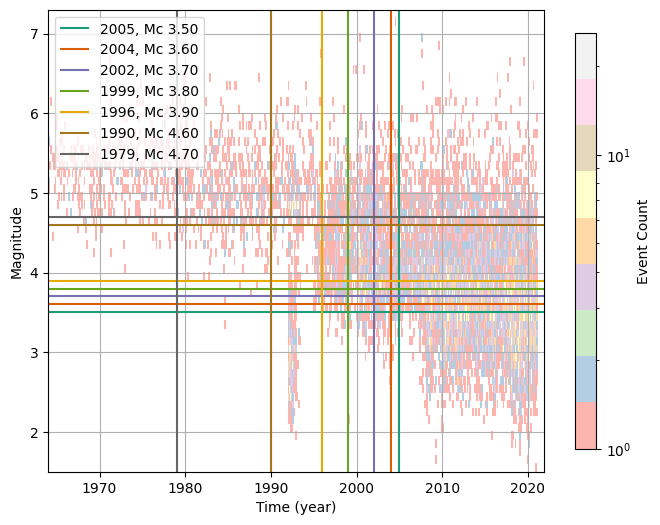

In [55]:
magnitude_bin_width = 0.1
time_bin_width = 0.1

plt.set_cmap('Pastel1')
plot_magnitude_time_density(catalogue_declustered, magnitude_bin_width, time_bin_width)
cmap = get_cmap(len(completeness_table[:,0]), 'Dark2')
for i, (v, h) in enumerate(zip(completeness_table[:,0],completeness_table[:,1])):
    plt.axvline(v, c=cmap(i), label=f"{v:.0f}, Mc {h:.2f}")
    plt.axhline(h, c=cmap(i))
plt.legend()
plt.savefig(os.path.join(dir_figs, 'plot_magnitude_time_density_Mc-catalogue_declustered.png'), dpi=300)

### 5.4.2 Plot Mc di Annual Rate

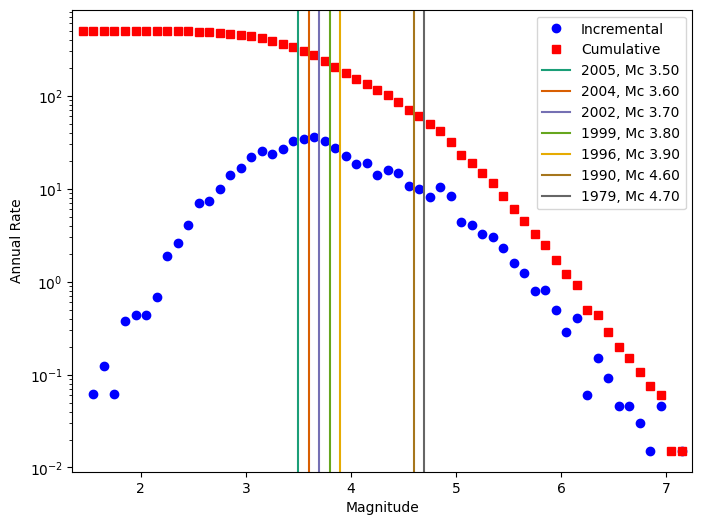

In [54]:
magnitude_bin_width = 0.1

plot_observed_recurrence(catalogue_declustered, completeness_table_old, magnitude_bin_width)
cmap = get_cmap(len(completeness_table[:,0]), 'Dark2')
for i, (v, h) in enumerate(zip(completeness_table[:,0],completeness_table[:,1])):
    plt.axvline(h, c=cmap(i), label=f"{v:.0f}, Mc {h:.2f}")
plt.legend()
plt.savefig(os.path.join(dir_figs, 'plot_observed_recurrence_Mc-catalogue_declustered.png'), dpi=300)